In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [25]:
df = pd.read_csv('diabetes.csv')

df[list(df.columns)[:-1]] = df[list(df.columns)[:-1]].replace(0, np.NaN)
df[list(df.columns)[:-1]] = pd.DataFrame(IterativeImputer(max_iter=10, random_state=0).fit_transform(df[list(df.columns)[:-1]]), columns=df[list(df.columns)[:-1]].columns)

index = 0
features = list(df.columns)[:-1]
for feature1 in features:
    for feature2 in features:
        if feature1 != feature2:
            df[f'F{index}'] = df[feature1] * df[feature2]
            df[f'F{index+1}'] = df[feature1] / df[feature2]
            index += 2

df.loc[:,'N1']=0
df.loc[(df['Age']<=30) & (df['Glucose']<=120),'N1']=1
df.loc[:,'N2']=0
df.loc[(df['BMI']<=30),'N2']=1
df.loc[:,'N3']=0
df.loc[(df['Age']<=30) & (df['Pregnancies']<=6),'N3']=1
df.loc[:,'N4']=0
df.loc[(df['Glucose']<=105) & (df['BloodPressure']<=80),'N4']=1
df.loc[:,'N5']=0
df.loc[(df['SkinThickness']<=20) ,'N5']=1
df.loc[:,'N6']=0
df.loc[(df['BMI']<30) & (df['SkinThickness']<=20),'N6']=1
df.loc[:,'N7']=0
df.loc[(df['Glucose']<=105) & (df['BMI']<=30),'N7']=1
df.loc[:,'N9']=0
df.loc[(df['Insulin']<200),'N9']=1
df.loc[:,'N10']=0
df.loc[(df['BloodPressure']<80),'N10']=1
df.loc[:,'N11']=0
df.loc[(df['Pregnancies']<4) & (df['Pregnancies']!=0) ,'N11']=1

import math

high_corr = df.corr()[abs(df.corr())>=.9]

del_cols = []
for row in range(len(high_corr)):
    for col in range(len(high_corr)):
        if row > col and not math.isnan(high_corr.iloc[row, col]):
            del_cols.append(row)
del_cols = list(set(del_cols))
del_cols = [list(df.columns)[i] for i in del_cols]
df = df.drop(columns=list(set(del_cols)))


X = df.drop(columns=['Outcome'])
y = df['Outcome']

# X = pd.get_dummies(data = X,columns = X.columns)

X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

X

C:\Users\rando\AppData\Local\Temp/ipykernel_14776/4113745635.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'F{index+1}'] = df[feature1] / df[feature2]
C:\Users\rando\AppData\Local\Temp/ipykernel_14776/4113745635.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'F{index}'] = df[feature1] * df[feature2]
C:\Users\rando\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,F1,F5,...,N1,N2,N3,N4,N5,N6,N7,N9,N10,N11
0,0.532648,0.865673,-0.029828,0.640076,0.695110,0.167923,0.468492,1.425995,0.114266,0.075700,...,-0.736321,-0.787562,-1.072968,-0.651814,-0.486534,-0.430331,-0.440910,-1.861482,0.609449,-1.031754
1,-1.113512,-1.203506,-0.524085,0.009313,-0.826904,-0.850370,-0.365061,-0.190672,-0.926240,-1.014180,...,-0.736321,1.269742,-1.072968,1.534181,-0.486534,-0.430331,2.268039,0.537206,0.609449,0.969223
2,1.191112,2.015217,-0.688837,-0.803034,1.150374,-1.330422,0.604397,-0.105584,0.229082,1.704323,...,-0.736321,1.269742,-1.072968,-0.651814,-0.486534,-0.430331,-0.440910,-1.861482,0.609449,-1.031754
3,-1.113512,-1.072129,-0.524085,-0.621449,-0.598350,-0.632164,-0.920763,-1.041549,-0.945359,-0.942589,...,1.358103,1.269742,0.931994,1.534181,-0.486534,-0.430331,2.268039,0.537206,0.609449,0.969223
4,-0.050513,0.504388,-2.665865,0.640076,0.160360,1.549893,5.484909,-0.020496,-0.235534,-0.327062,...,-0.736321,-0.787562,-1.072968,-0.651814,-0.486534,-0.430331,-0.440910,0.537206,0.609449,-1.031754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,1.849576,-0.678000,0.299676,2.006728,0.283394,0.066094,-0.908682,2.532136,2.228462,0.369406,...,-0.736321,-0.787562,-1.072968,1.534181,-0.486534,-0.430331,-0.440910,0.537206,0.609449,-1.031754
764,-0.784280,0.011726,-0.194580,-0.200941,0.085573,0.633429,-0.398282,-0.531023,-0.758870,-0.699093,...,-0.736321,-0.787562,0.931994,-0.651814,-0.486534,-0.430331,-0.440910,0.537206,0.609449,0.969223
765,0.203416,-0.021118,-0.029828,-0.621449,-0.413799,-0.908558,-0.685193,-0.275760,0.142534,0.441493,...,-0.736321,1.269742,0.931994,-0.651814,-0.486534,-0.430331,-0.440910,0.537206,0.609449,-1.031754
766,-1.113512,0.143103,-1.018342,-0.074636,0.263228,-0.341223,-0.371101,1.170732,-1.064664,-1.006409,...,-0.736321,-0.787562,-1.072968,-0.651814,-0.486534,-0.430331,-0.440910,0.537206,0.609449,0.969223


In [37]:
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

model = LogisticRegression(max_iter=1000,
                           tol=1e-6, 
                           solver='saga',
                           C=0.01)

scores = []
for train_index , test_index in kfold.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
    # X_train, y_train = SMOTE(random_state=0).fit_resample(X_train, y_train)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    # sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
    # plt.show()
    scores.append(accuracy_score(y_test, y_pred) * 100)

np.mean(scores), np.std(scores)

(76.81989063568011, 4.938732382218265)

LR: 0.763004 (0.045656)
LDA: 0.753913 (0.045400)
KNN: 0.710919 (0.051365)
CART: 0.695318 (0.047074)
NB: 0.743387 (0.053097)
SVM: 0.746104 (0.047895)


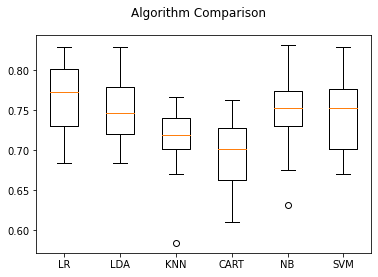

In [27]:
models = []
models.append(('LR', LogisticRegression(max_iter =1000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(max_iter =1000)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

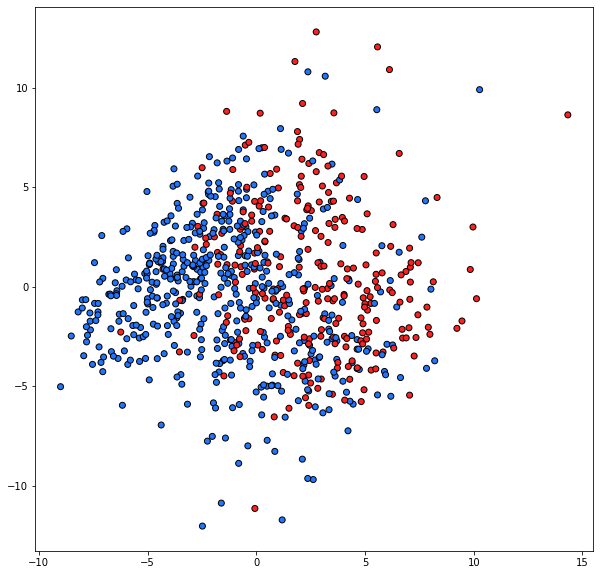

In [30]:
from sklearn.decomposition import PCA

pca = PCA().fit(X)

pc = pca.transform(X)
pc1 = pc[:,0]
pc2 = pc[:,1]

#Plot principal components
plt.figure(figsize=(10,10))

colour = ['#ff2121' if label == 1 else '#2176ff' for label in y]
plt.scatter(pc1,pc2 ,c=colour,edgecolors='#000000')

In [35]:
param = {'penalty': ['l1', 'l2', 'elasticnet'],
         'tol': [1e-4, 1e-5, 1e-6],
         'C': [0.01, 0.1, 1, 10],
         'class_weight': [None, 'balanced'],
         'solver': ['netwon-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

clf = RandomizedSearchCV(LogisticRegression(random_state=0, max_iter=1000), param, n_iter=100, scoring='accuracy', n_jobs=-1, cv=5, random_state=0)
search = clf.fit(X, y)
search.best_params_

C:\Users\rando\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
285 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rando\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rando\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py", line 1471, in fit
    raise ValueError(
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

------------------------------------------------------------

{'tol': 1e-06,
 'solver': 'sag',
 'penalty': 'l2',
 'class_weight': None,
 'C': 0.01}